# PET In-vitro data

## Imports

In [1]:
%reload_ext autoreload
%reload_ext jupyter_black
%autoreload 2

In [2]:
import pandas as pd
import plotnine as p9
from Levenshtein import distance

In [3]:
from src import utils

In [4]:
double_split = pd.read_csv("input/invitro-double-split.csv", index_col=0)

In [5]:
def replicate_table(
    df: pd.DataFrame, exclude_plates: list = (), annotation: dict = {}
) -> pd.DataFrame:
    dd = (
        df[["plate_name", "sequence", "objectid", "team", "output"]]
        .loc[lambda d: ~d.plate_name.isin(list(exclude_plates))]
        .drop(columns=["plate_name"])
        .drop_duplicates(subset=["sequence", "team", "objectid"])
        .merge(double_split, how="left")
        .drop(columns=["objectid"])
        .groupby(["sequence", "team", "split", "same_plate"])
        .mean(numeric_only=True)
        .reset_index()
        .set_index(["sequence", "same_plate", "team", "split"])
        .unstack()
        .reset_index()
        .assign(**annotation)
    )
    dd.columns = [a if b == "" else b for a, b in dd.columns]
    return dd

In [6]:
ref = "LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD"

## Expression (HPLC) 

In [7]:
df = pd.read_csv(
    "input/invitro-summaries-share-repeat-2.csv.gz", index_col=0, low_memory=False
)

In [8]:
exp = (
    df.loc[lambda d: d.data_analysis_protocol == "CONCENTRATIONASSAY"]
    .groupby("testset", as_index=False)
    .apply(
        utils.summary_to_training,
        pi_stat="blank_corrected_result_mean",
        concentration_min=-999,
    )
    .reset_index(drop=True)
)

/var/folders/kr/04pmmtp555vg9xcspkt2lldr0000gn/T/ipykernel_91293/840984133.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Visible plate effects? No.

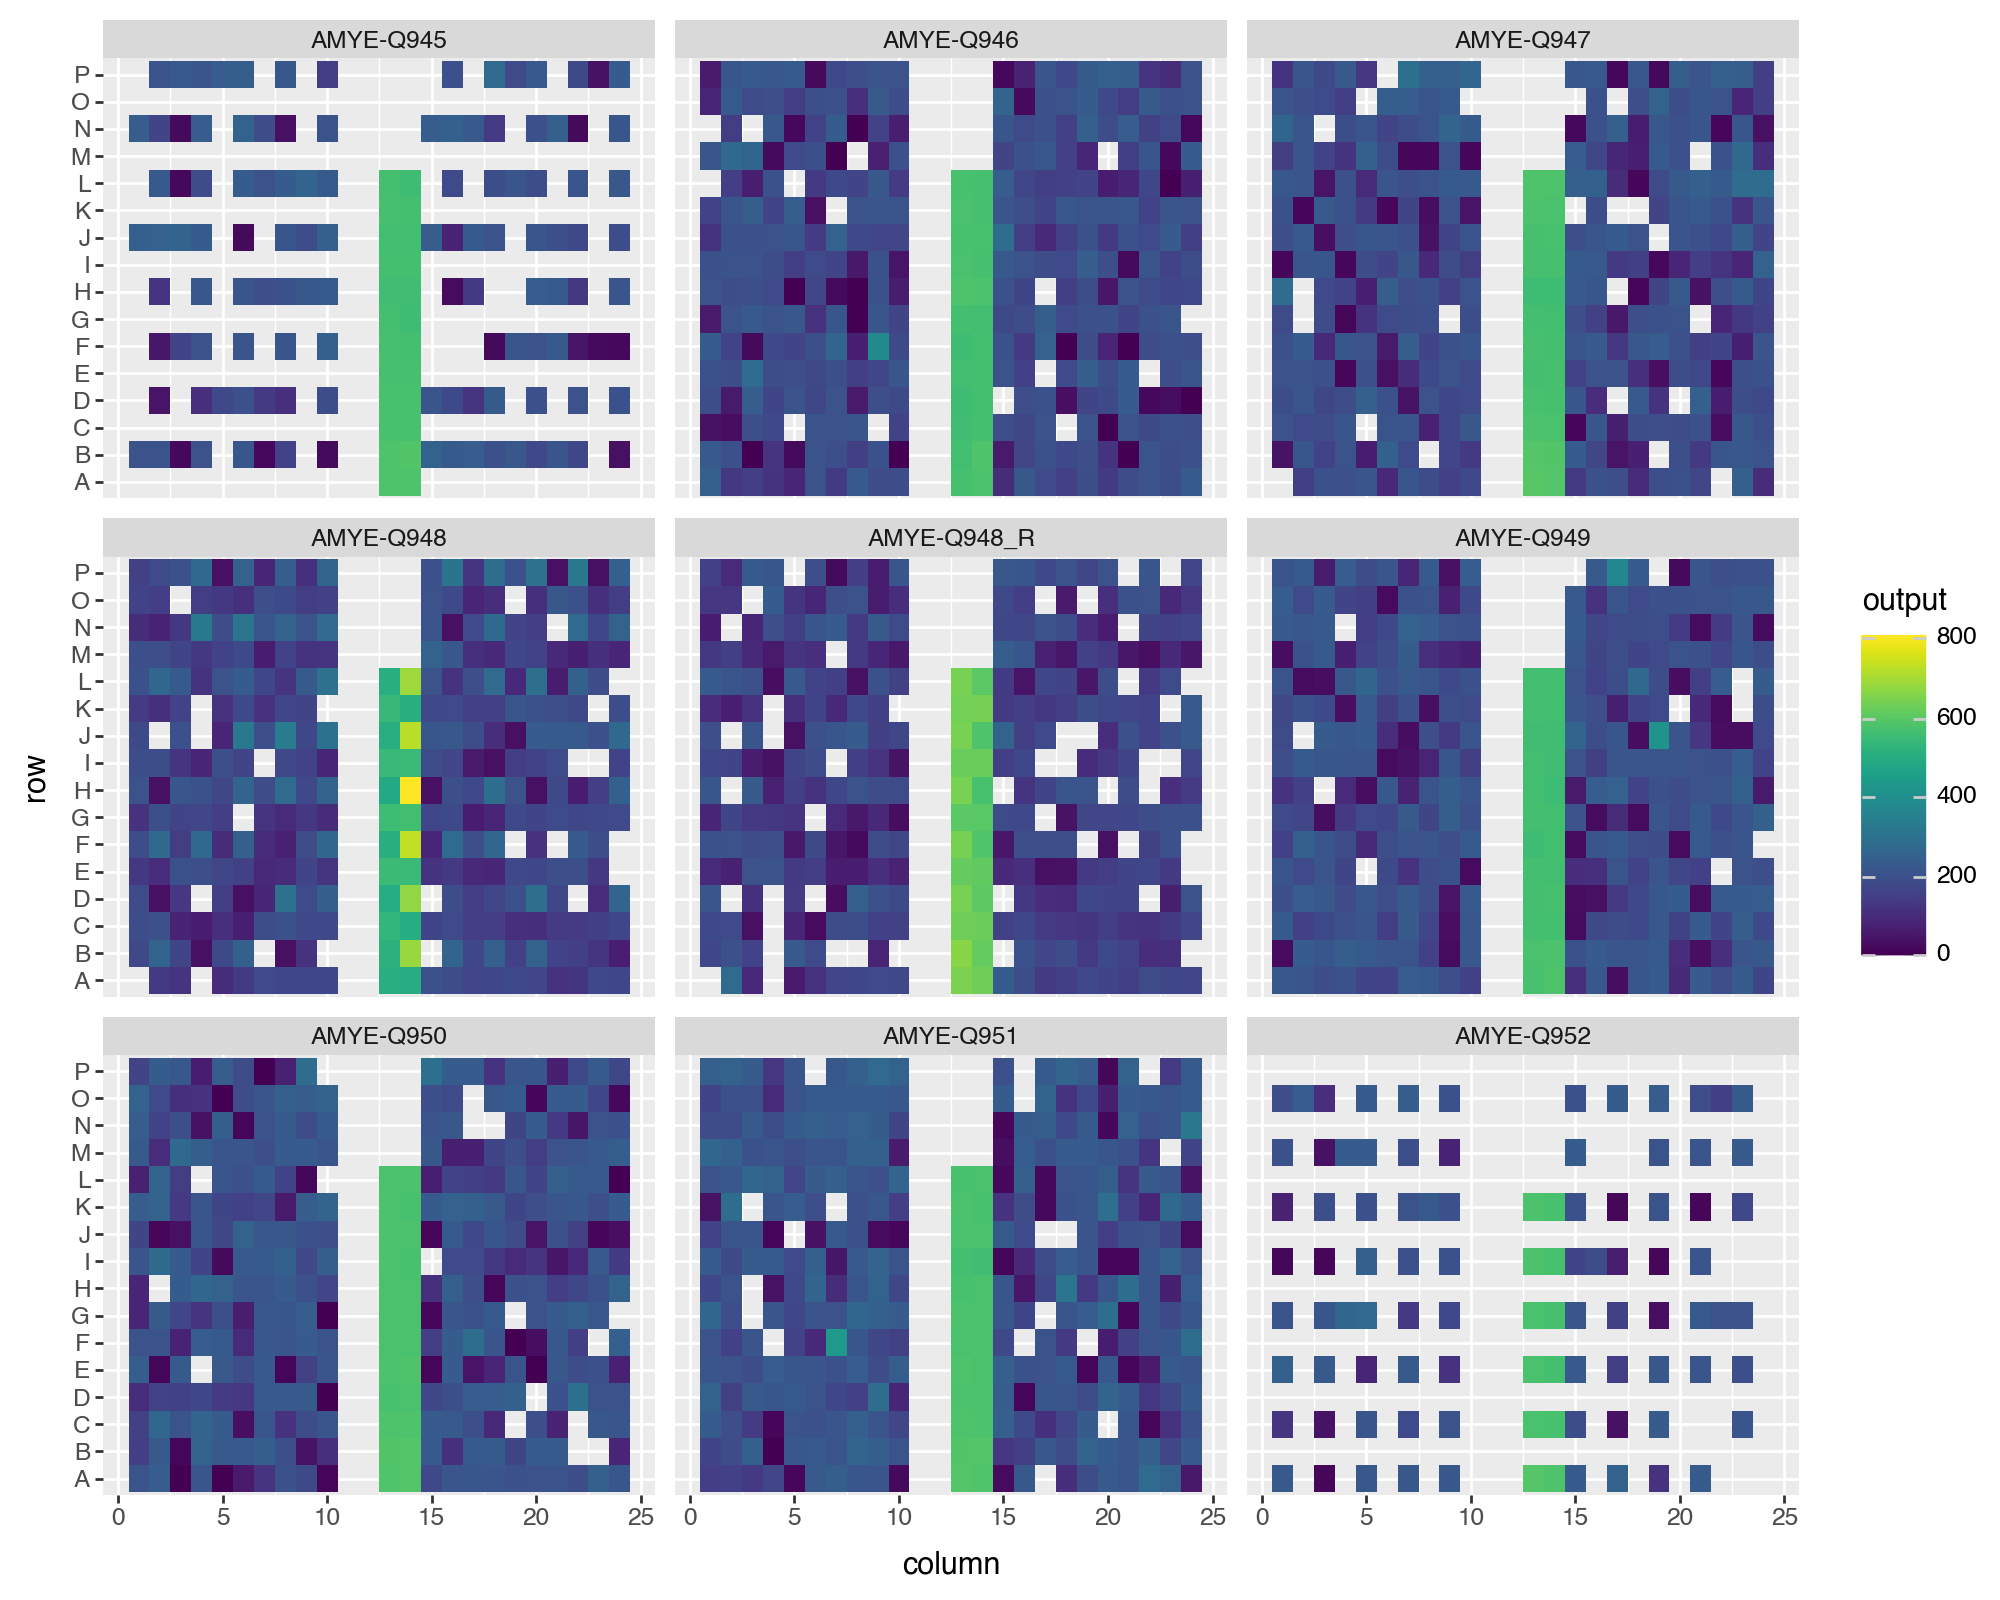

In [9]:
p9.options.set_option("figure_size", (10, 8))
(
    p9.ggplot(exp, p9.aes("column", "row", fill="output"))
    + p9.geom_tile()
    + p9.facet_wrap("~ plate_name")
)

HPLC pump failure on plate Q948 which was therefore repeated (much later) to Q948_R.

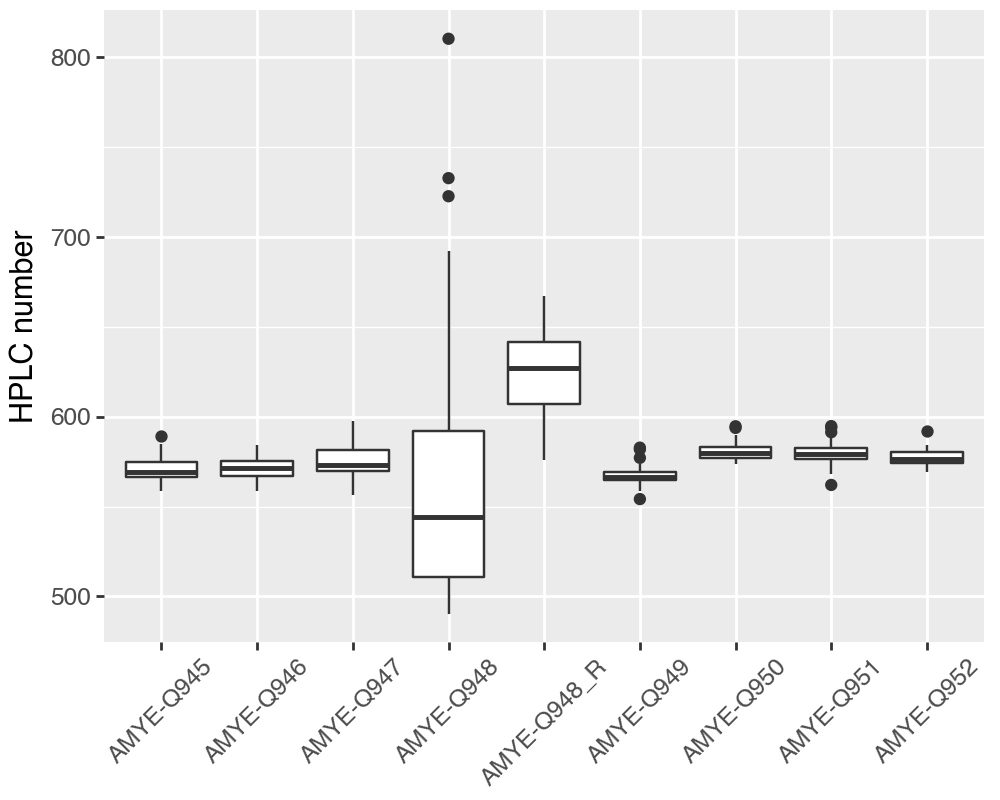

In [10]:
p9.options.set_option("figure_size", (5, 4))
(
    p9.ggplot(
        exp.query("analysis_role == 'CONTROL'"),
        p9.aes("plate_name", "output"),
    )
    + p9.geom_boxplot()
    + p9.ylab("HPLC number")
    + p9.theme(axis_text_x=p9.element_text(angle=45))
    + p9.xlab("")
)

Which of the two runs of Q948 is better? Both are deviant looking at the controls.

In [11]:
expn = utils.plate_median_normalize(exp.copy(), controls=["AMYE-WT"])

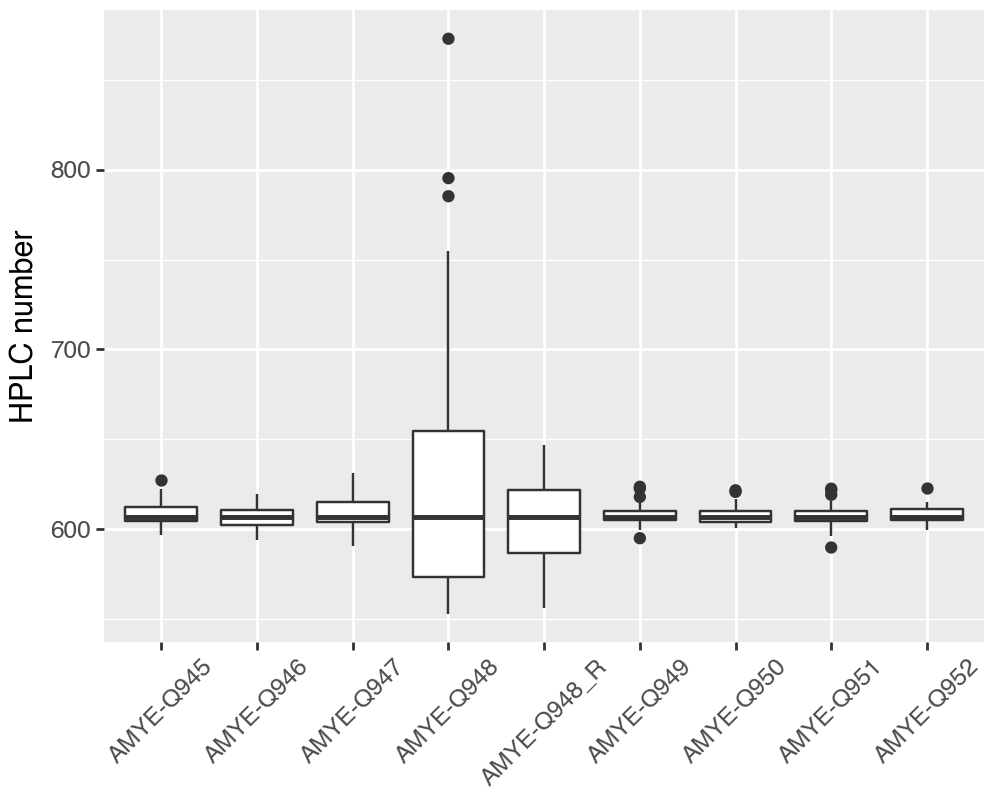

In [12]:
p9.options.set_option("figure_size", (5, 4))
(
    p9.ggplot(expn.query("analysis_role == 'CONTROL'"), p9.aes("plate_name", "output"))
    + p9.geom_boxplot()
    + p9.ylab("HPLC number")
    + p9.theme(axis_text_x=p9.element_text(angle=45))
    + p9.xlab("")
)

In [13]:
orig_ds = replicate_table(
    exp,
    exclude_plates=["AMYE-Q948_R"],
    annotation={"data": "original"},
)
rep_ds = replicate_table(
    exp, exclude_plates=["AMYE-Q948"], annotation={"data": "repeat"}
)

In [14]:
dss = pd.concat([orig_ds, rep_ds])

Original data yields ever so slightly higher correlation so we keep that.

In [15]:
dss.drop(columns=["same_plate"]).groupby(["data"]).corr(
    numeric_only=True, method="spearman"
)

s0        s1
data                           
original s0  1.000000  0.739387
         s1  0.739387  1.000000
repeat   s0  1.000000  0.727852
         s1  0.727852  1.000000

In [16]:
exp = exp.loc[lambda d: d.plate_name != "AMYE-Q948_R"].copy()

In [17]:
dswo = replicate_table(
    exp,
    exclude_plates=["AMYE-Q948"],
    annotation={"normalized": "Not normalized", "with_Q948": "Without Q948"},
)
dsw = replicate_table(
    exp, annotation={"normalized": "Not normalized", "with_Q948": "With Q948"}
)
dsnwo = replicate_table(
    expn,
    exclude_plates=["AMYE-Q948"],
    annotation={"normalized": "Normalized", "with_Q948": "Without Q948"},
)
dsnw = replicate_table(
    expn, annotation={"normalized": "Normalized", "with_Q948": "With Q948"}
)

In [18]:
dss = pd.concat([dswo, dsw, dsnwo, dsnw])

In [19]:
dss.drop(columns=["same_plate"]).groupby(["with_Q948", "normalized"]).corr(
    numeric_only=True, method="spearman"
)

s0        s1
with_Q948    normalized                           
With Q948    Normalized     s0  1.000000  0.741114
                            s1  0.741114  1.000000
             Not normalized s0  1.000000  0.739387
                            s1  0.739387  1.000000
Without Q948 Normalized     s0  1.000000  0.641710
                            s1  0.641710  1.000000
             Not normalized s0  1.000000  0.786935
                            s1  0.786935  1.000000

- Normalization is not a good idea
- Q948 remains problematic despite re-run, original was slightly better

/Users/henning/.virtualenvs/pet-pilot/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 291 rows containing missing values.


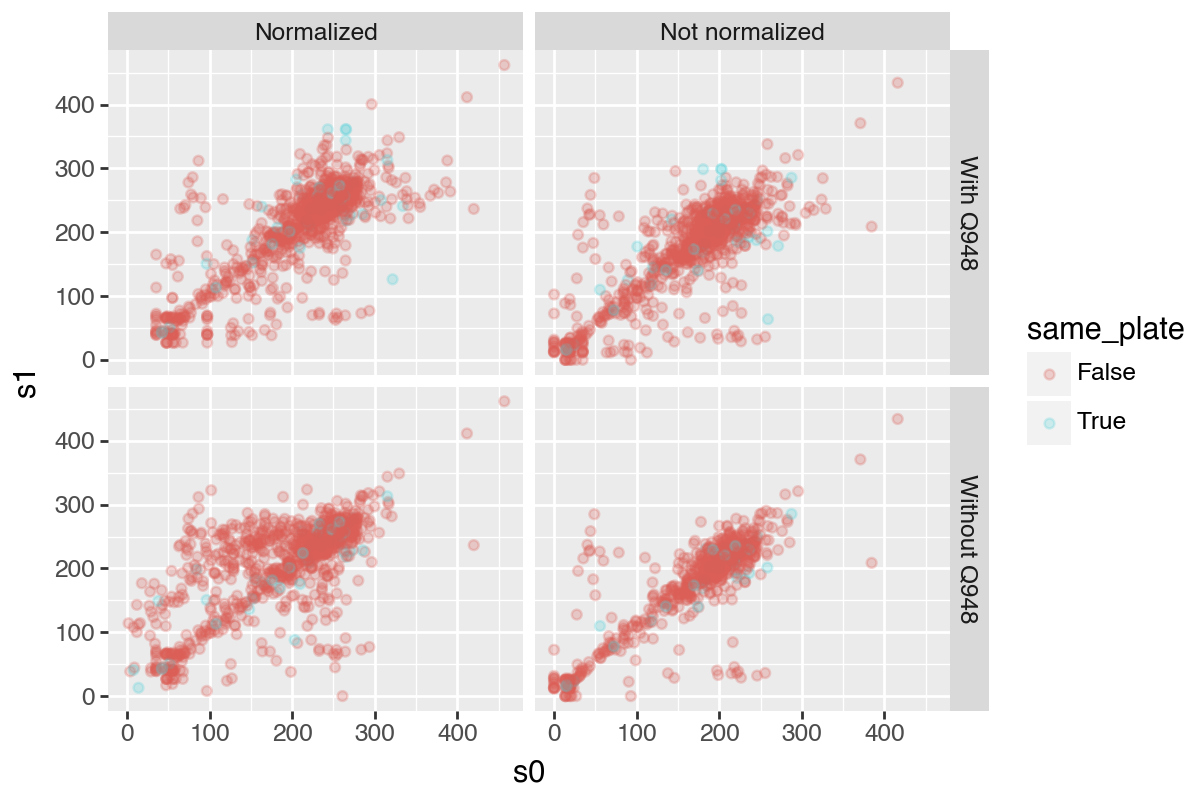

In [20]:
p9.options.set_option("figure_size", (6, 4))
(
    p9.ggplot(dss, p9.aes(x="s0", y="s1", color="same_plate"))
    + p9.geom_point(alpha=0.25)
    + p9.facet_grid("with_Q948~normalized")
)

In [21]:
f = exp[
    [
        "team",
        "sequence",
        "objectid",
        "plate_name",
        "well_location",
        "analysis_role",
        "output",
    ]
].assign(target="expression")

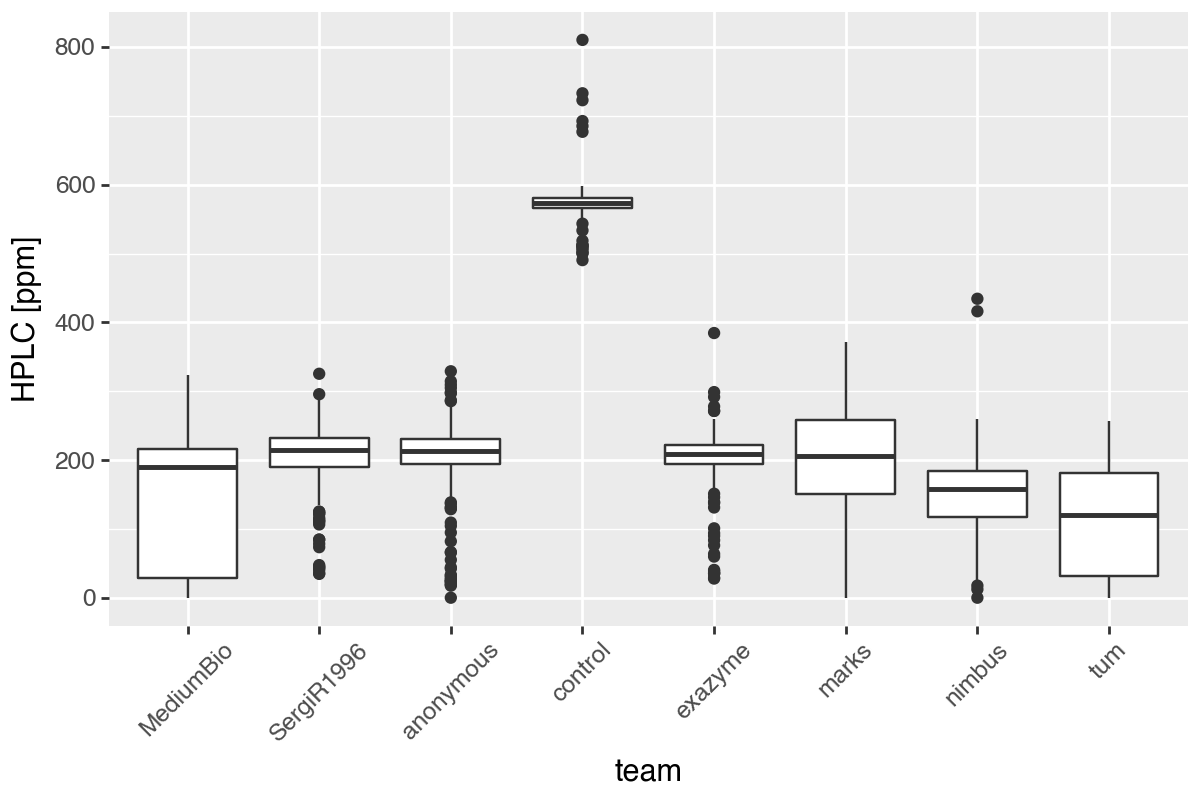

In [22]:
(
    p9.ggplot(f, p9.aes("team", "output"))
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(angle=45))
    + p9.ylab("HPLC [ppm]")
)

In [23]:
f.to_csv("output/invitro-hplc.csv.gz")

## Specific activity

We take the unstressed data from the stability assay and remove replace the well-concentration column with the estimates from the HPLC assay. We then form specific activity by ratio between activity and well-concentration.

In [24]:
df = (
    pd.read_csv(
        "input/invitro-summaries-share-repeat-2.csv.gz", index_col=0, low_memory=False
    )
    .query("data_analysis_protocol == 'RESIDUALACTIVITYASSAY'")
    .assign(data_analysis_protocol="SPECIFICACTIVITYASSAY")
    .drop(columns=["well_concentration"])
)

In [25]:
exp = (
    pd.read_csv("output/invitro-hplc.csv.gz", index_col=0)[
        ["plate_name", "well_location", "output"]
    ]
    .loc[lambda d: d.plate_name != "AMYE-Q948_R"]
    .drop_duplicates()
    .rename(columns={"output": "well_concentration"})
    # only keep variants with non-tiny expression
    .loc[lambda d: d.well_concentration > 50]
)

In [26]:
activity = (
    df.merge(exp)
    .pipe(
        utils.summary_to_training,
        ref="AMYE-WT-STD",
        pi_stat="blank_corrected_unstressed_result_mean",
        concentration_min=-999,
    )
    .assign(
        # negative values should be zero
        unstressed=lambda d: d.output.clip(0),
        output=lambda d: d.unstressed / d.well_concentration,
    )
    .reset_index(drop=True)
)

In [27]:
activity.sequence.nunique()

952

Visible plate effects? No

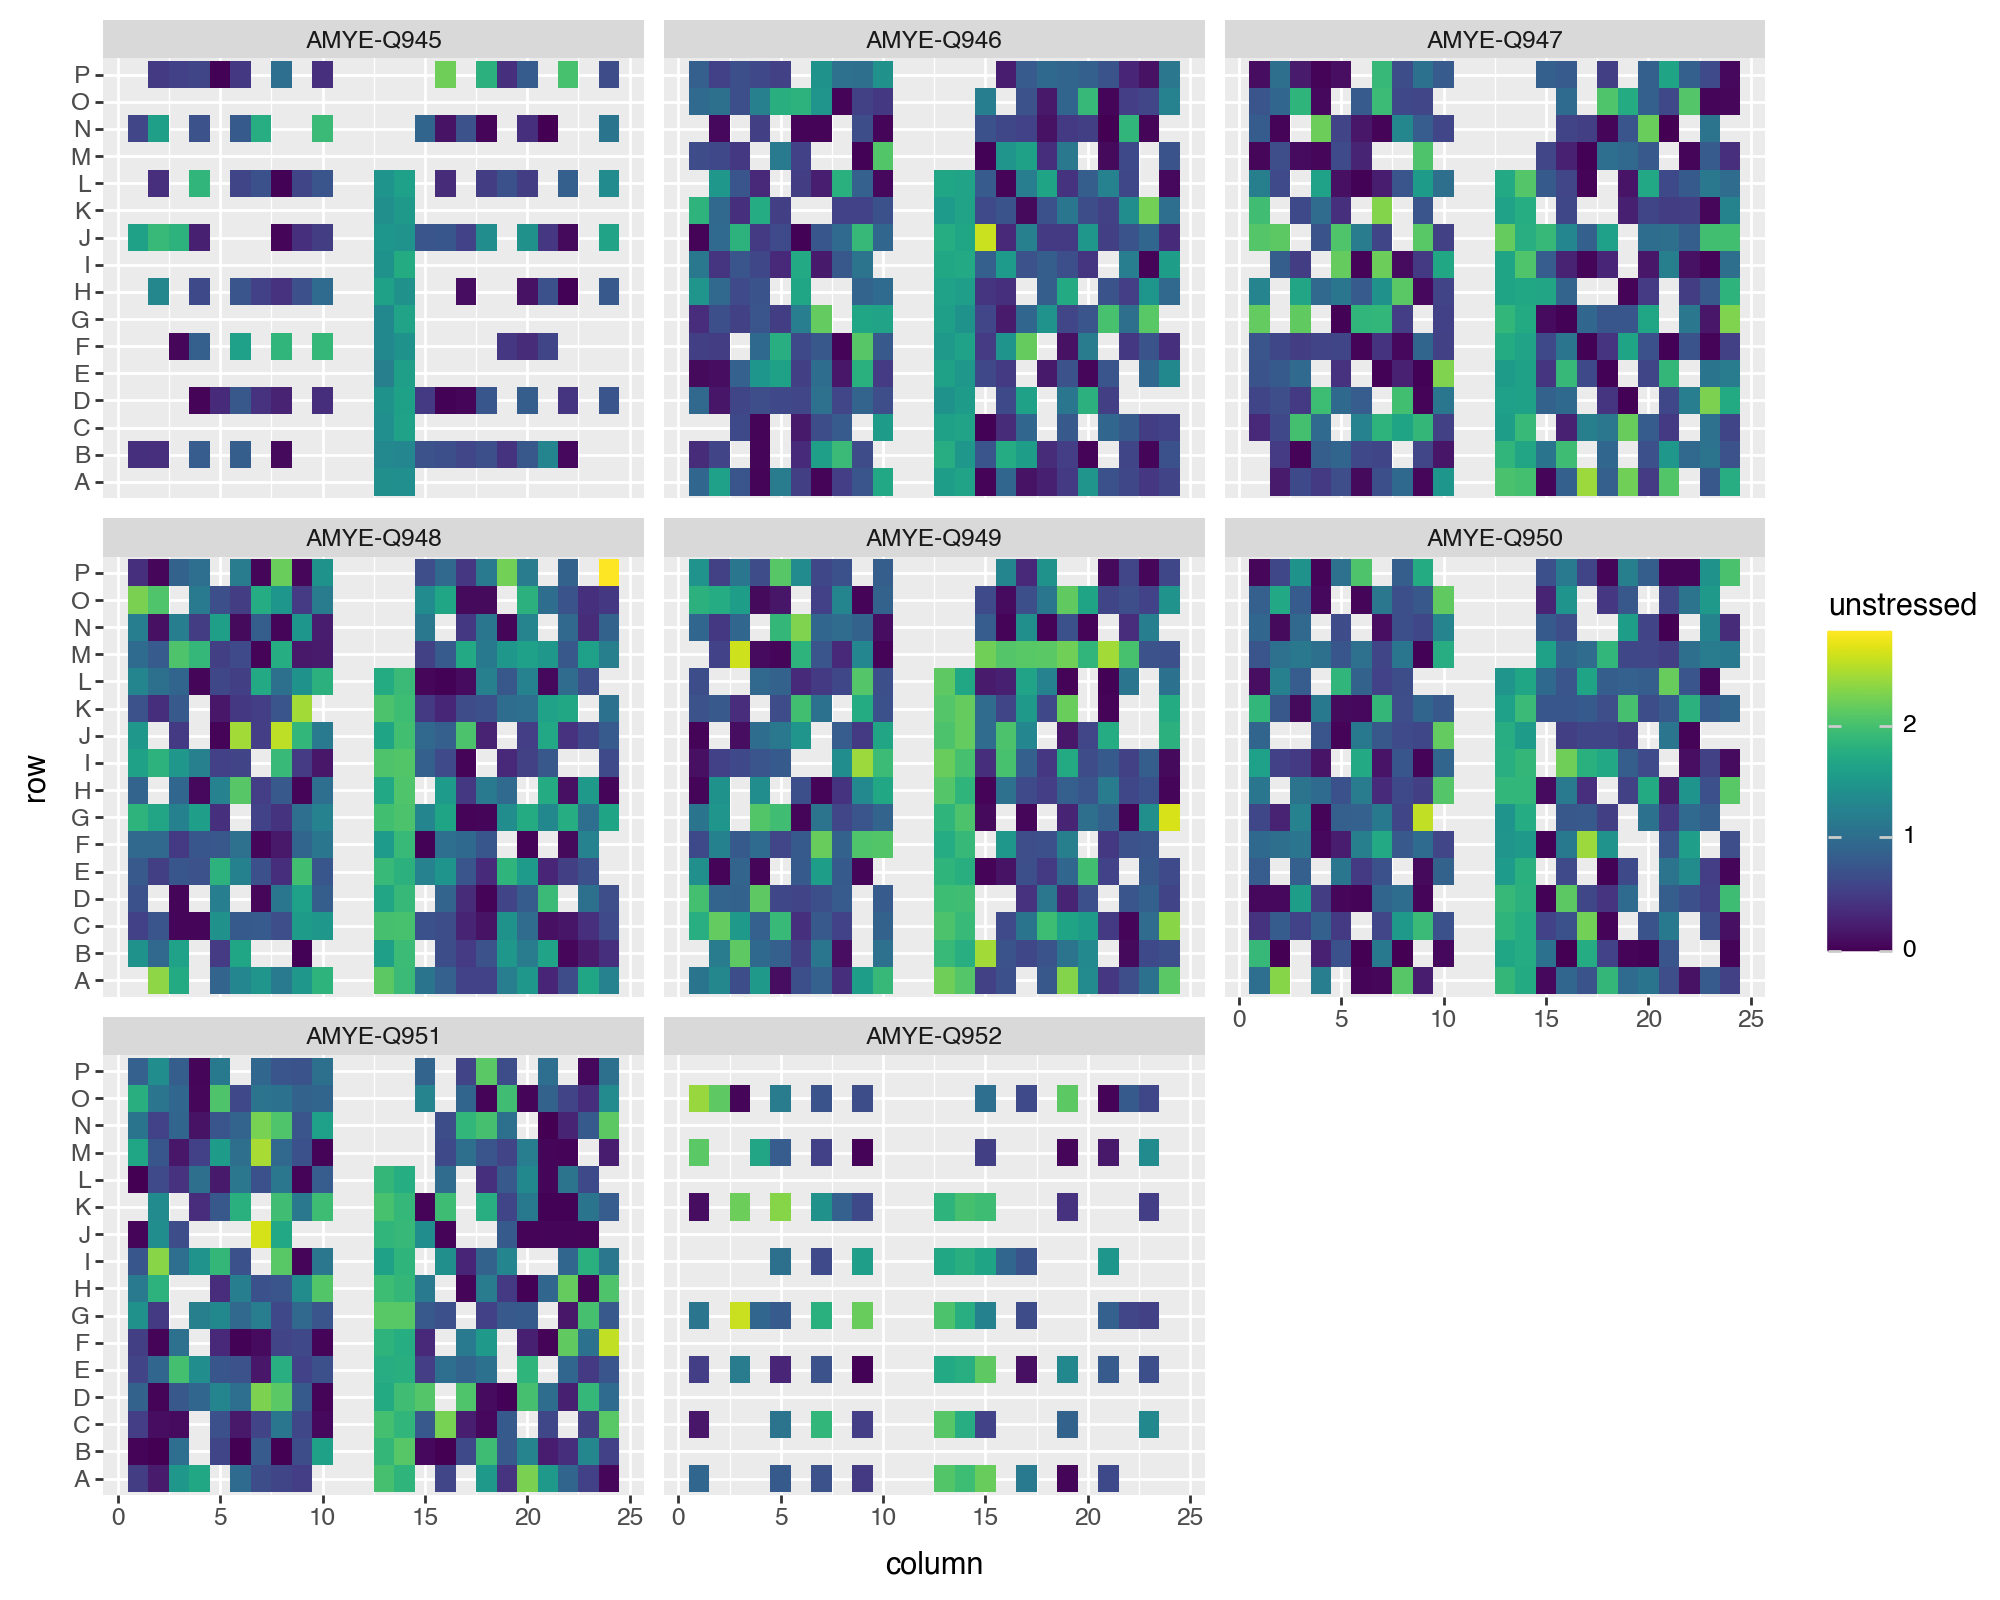

In [28]:
p9.options.set_option("figure_size", (10, 8))
(
    p9.ggplot(activity, p9.aes("column", "row", fill="unstressed"))
    + p9.geom_tile()
    + p9.facet_wrap("~ plate_name")
)

In [29]:
activityn = utils.plate_median_normalize(activity.copy(), controls=["AMYE-WT"])

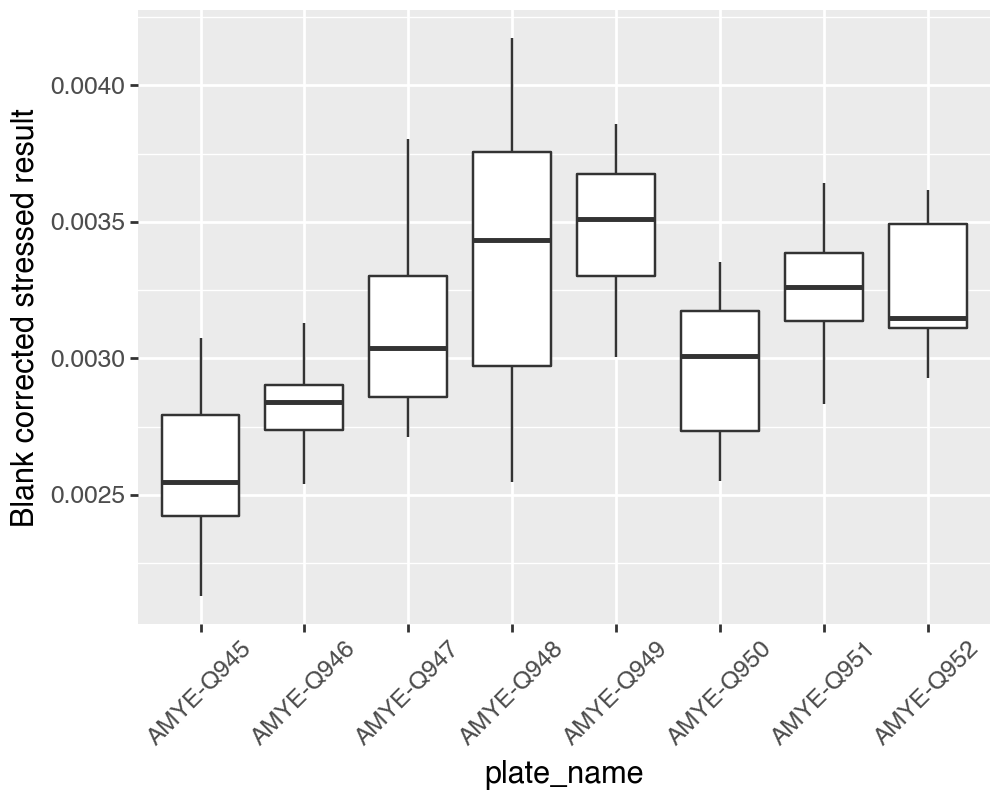

In [30]:
p9.options.set_option("figure_size", (5, 4))
(
    p9.ggplot(
        activity.query("analysis_role == 'CONTROL'"),
        p9.aes("plate_name", "output"),
    )
    + p9.geom_boxplot()
    + p9.ylab("Blank corrected stressed result")
    + p9.theme(axis_text_x=p9.element_text(angle=45))
)

Try median normalization. 

In [31]:
dswo = replicate_table(
    activity,
    exclude_plates=["AMYE-Q948"],
    annotation={"normalized": "Not normalized", "with_Q948": "Without Q948"},
)
dsw = replicate_table(
    activity, annotation={"normalized": "Not normalized", "with_Q948": "With Q948"}
)
dsnwo = replicate_table(
    activityn,
    exclude_plates=["AMYE-Q948"],
    annotation={"normalized": "Normalized", "with_Q948": "Without Q948"},
)
dsnw = replicate_table(
    activityn, annotation={"normalized": "Normalized", "with_Q948": "With Q948"}
)

In [32]:
dss = pd.concat([dswo, dsw, dsnwo, dsnw])

In [33]:
dss.drop(columns=["same_plate"]).groupby(["with_Q948", "normalized"]).corr(
    numeric_only=True, method="spearman"
)

s0        s1
with_Q948    normalized                           
With Q948    Normalized     s0  1.000000  0.881865
                            s1  0.881865  1.000000
             Not normalized s0  1.000000  0.872322
                            s1  0.872322  1.000000
Without Q948 Normalized     s0  1.000000  0.919316
                            s1  0.919316  1.000000
             Not normalized s0  1.000000  0.913347
                            s1  0.913347  1.000000

/Users/henning/.virtualenvs/pet-pilot/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 618 rows containing missing values.


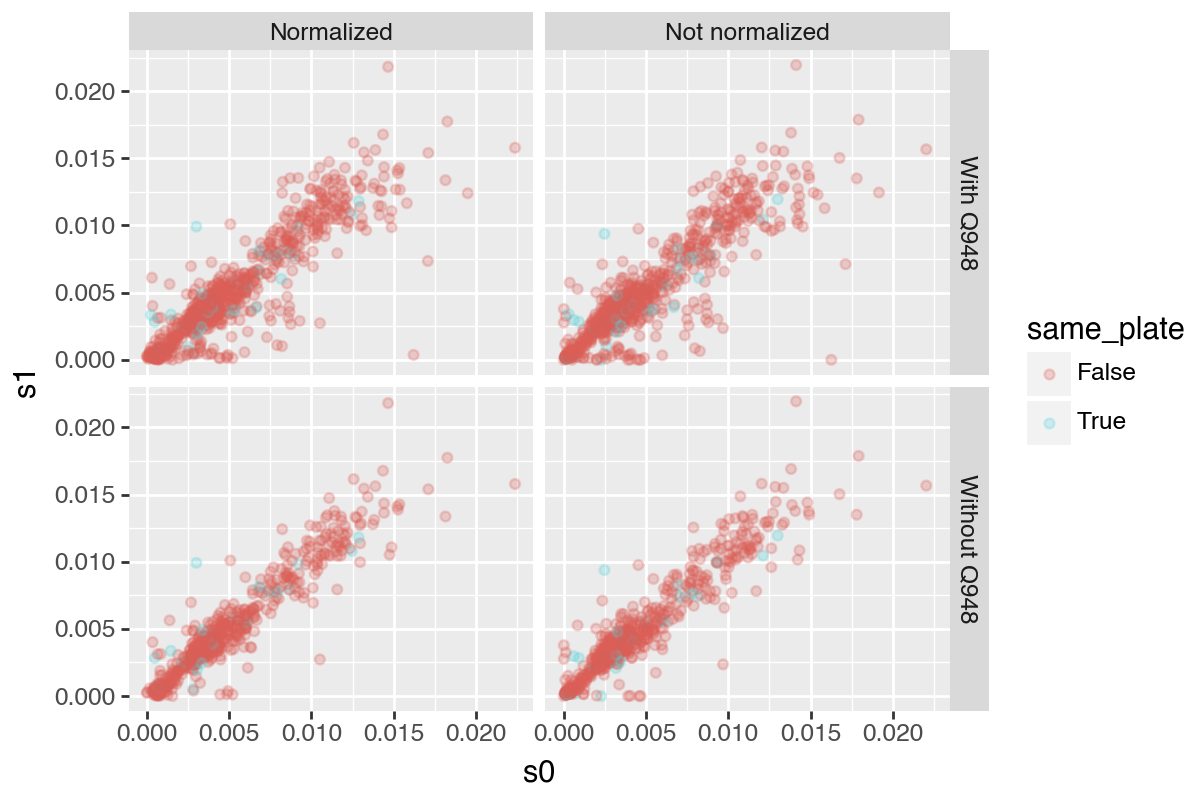

In [34]:
p9.options.set_option("figure_size", (6, 4))
(
    p9.ggplot(dss, p9.aes(x="s0", y="s1", color="same_plate"))
    + p9.geom_point(alpha=0.25)
    + p9.facet_grid("with_Q948~normalized")
)

In [35]:
f = activityn[
    [
        "team",
        "sequence",
        "objectid",
        "plate_name",
        "well_location",
        "analysis_role",
        "output",
    ]
].assign(target="specific_activity")

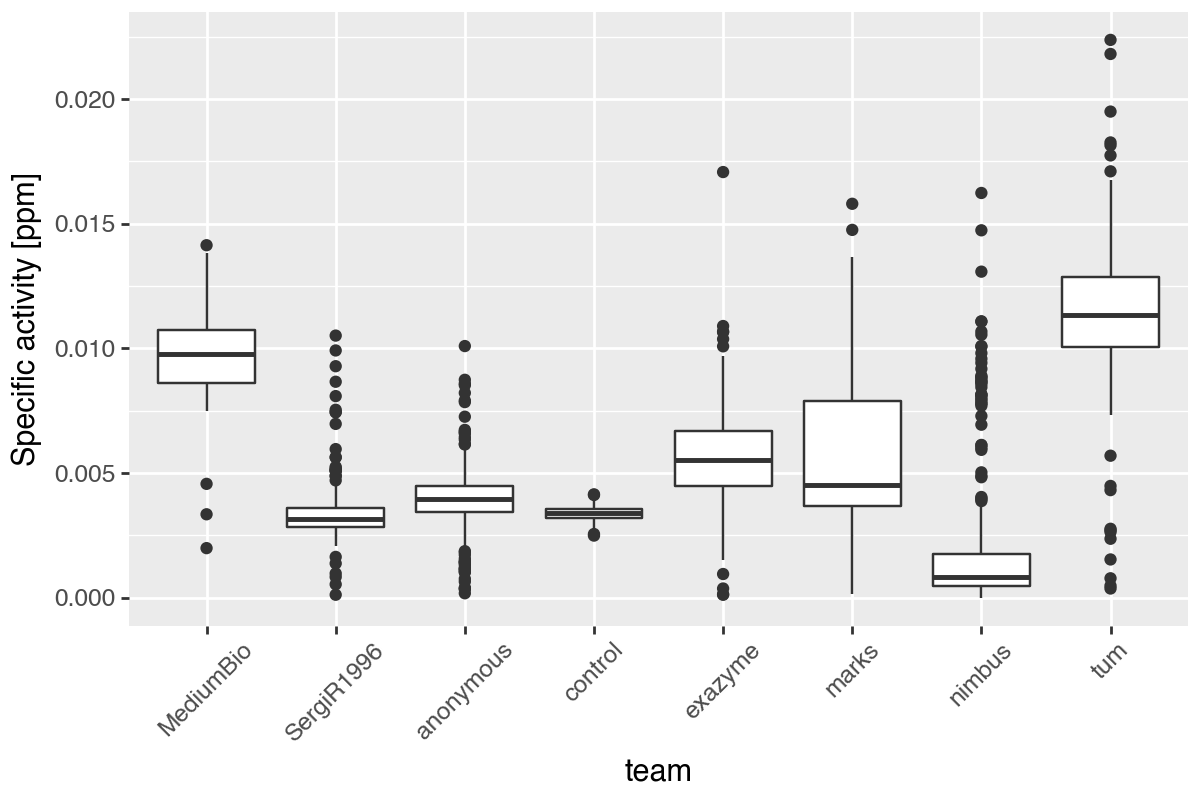

In [36]:
(
    p9.ggplot(f, p9.aes("team", "output"))
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(angle=45))
    + p9.ylab("Specific activity [ppm]")
)

In [37]:
f.to_csv("output/invitro-activity.csv.gz")

## Stability

We get the stability and add the expression estimates. Stability depends on both expression and unstressed activity being non-tiny.

In [38]:
df = (
    pd.read_csv(
        "input/invitro-summaries-share-repeat-2.csv.gz", index_col=0, low_memory=False
    )
    .query("data_analysis_protocol == 'RESIDUALACTIVITYASSAY'")
    .drop(columns=["well_concentration"])
)

In [39]:
exp = (
    pd.read_csv("output/invitro-hplc.csv.gz", index_col=0)[
        ["plate_name", "well_location", "output"]
    ]
    .drop_duplicates()
    .rename(columns={"output": "well_concentration"})
    # only keep variants with non-tiny expression
    .loc[lambda d: d.well_concentration > 50]
)

In [40]:
unstressed = (
    df.merge(exp)
    .pipe(
        utils.summary_to_training,
        ref="AMYE-WT-STD",
        pi_stat="blank_corrected_unstressed_result_mean",
        concentration_min=-999,
        unstressed_min=-999,
    )
    .assign(
        # negative values should be zero
        unstressed=lambda d: d.output.clip(0),
    )
    .reset_index(drop=True)[["plate_name", "well_location", "unstressed"]]
)

In [41]:
unstressed.head()

,plate_name,well_location,unstressed
0,AMYE-Q945,A013,1.420462
1,AMYE-Q945,A014,1.407929
2,AMYE-Q945,B001,0.393529
3,AMYE-Q945,B002,0.384729
4,AMYE-Q945,B004,0.826329


In [42]:
stability = (
    df.merge(exp)
    .pipe(
        utils.summary_to_training,
        ref="AMYE-WT-STD",
        pi_stat="residual_activity",
        concentration_min=-999,
        unstressed_min=0.001,
    )
    .reset_index(drop=True)
    .merge(unstressed, how="left")
    .loc[lambda d: d.unstressed >= 0.1]
    .loc[lambda d: d.well_concentration >= 50]
)

In [43]:
stability.sequence.nunique()

847

Visible plate effects? No

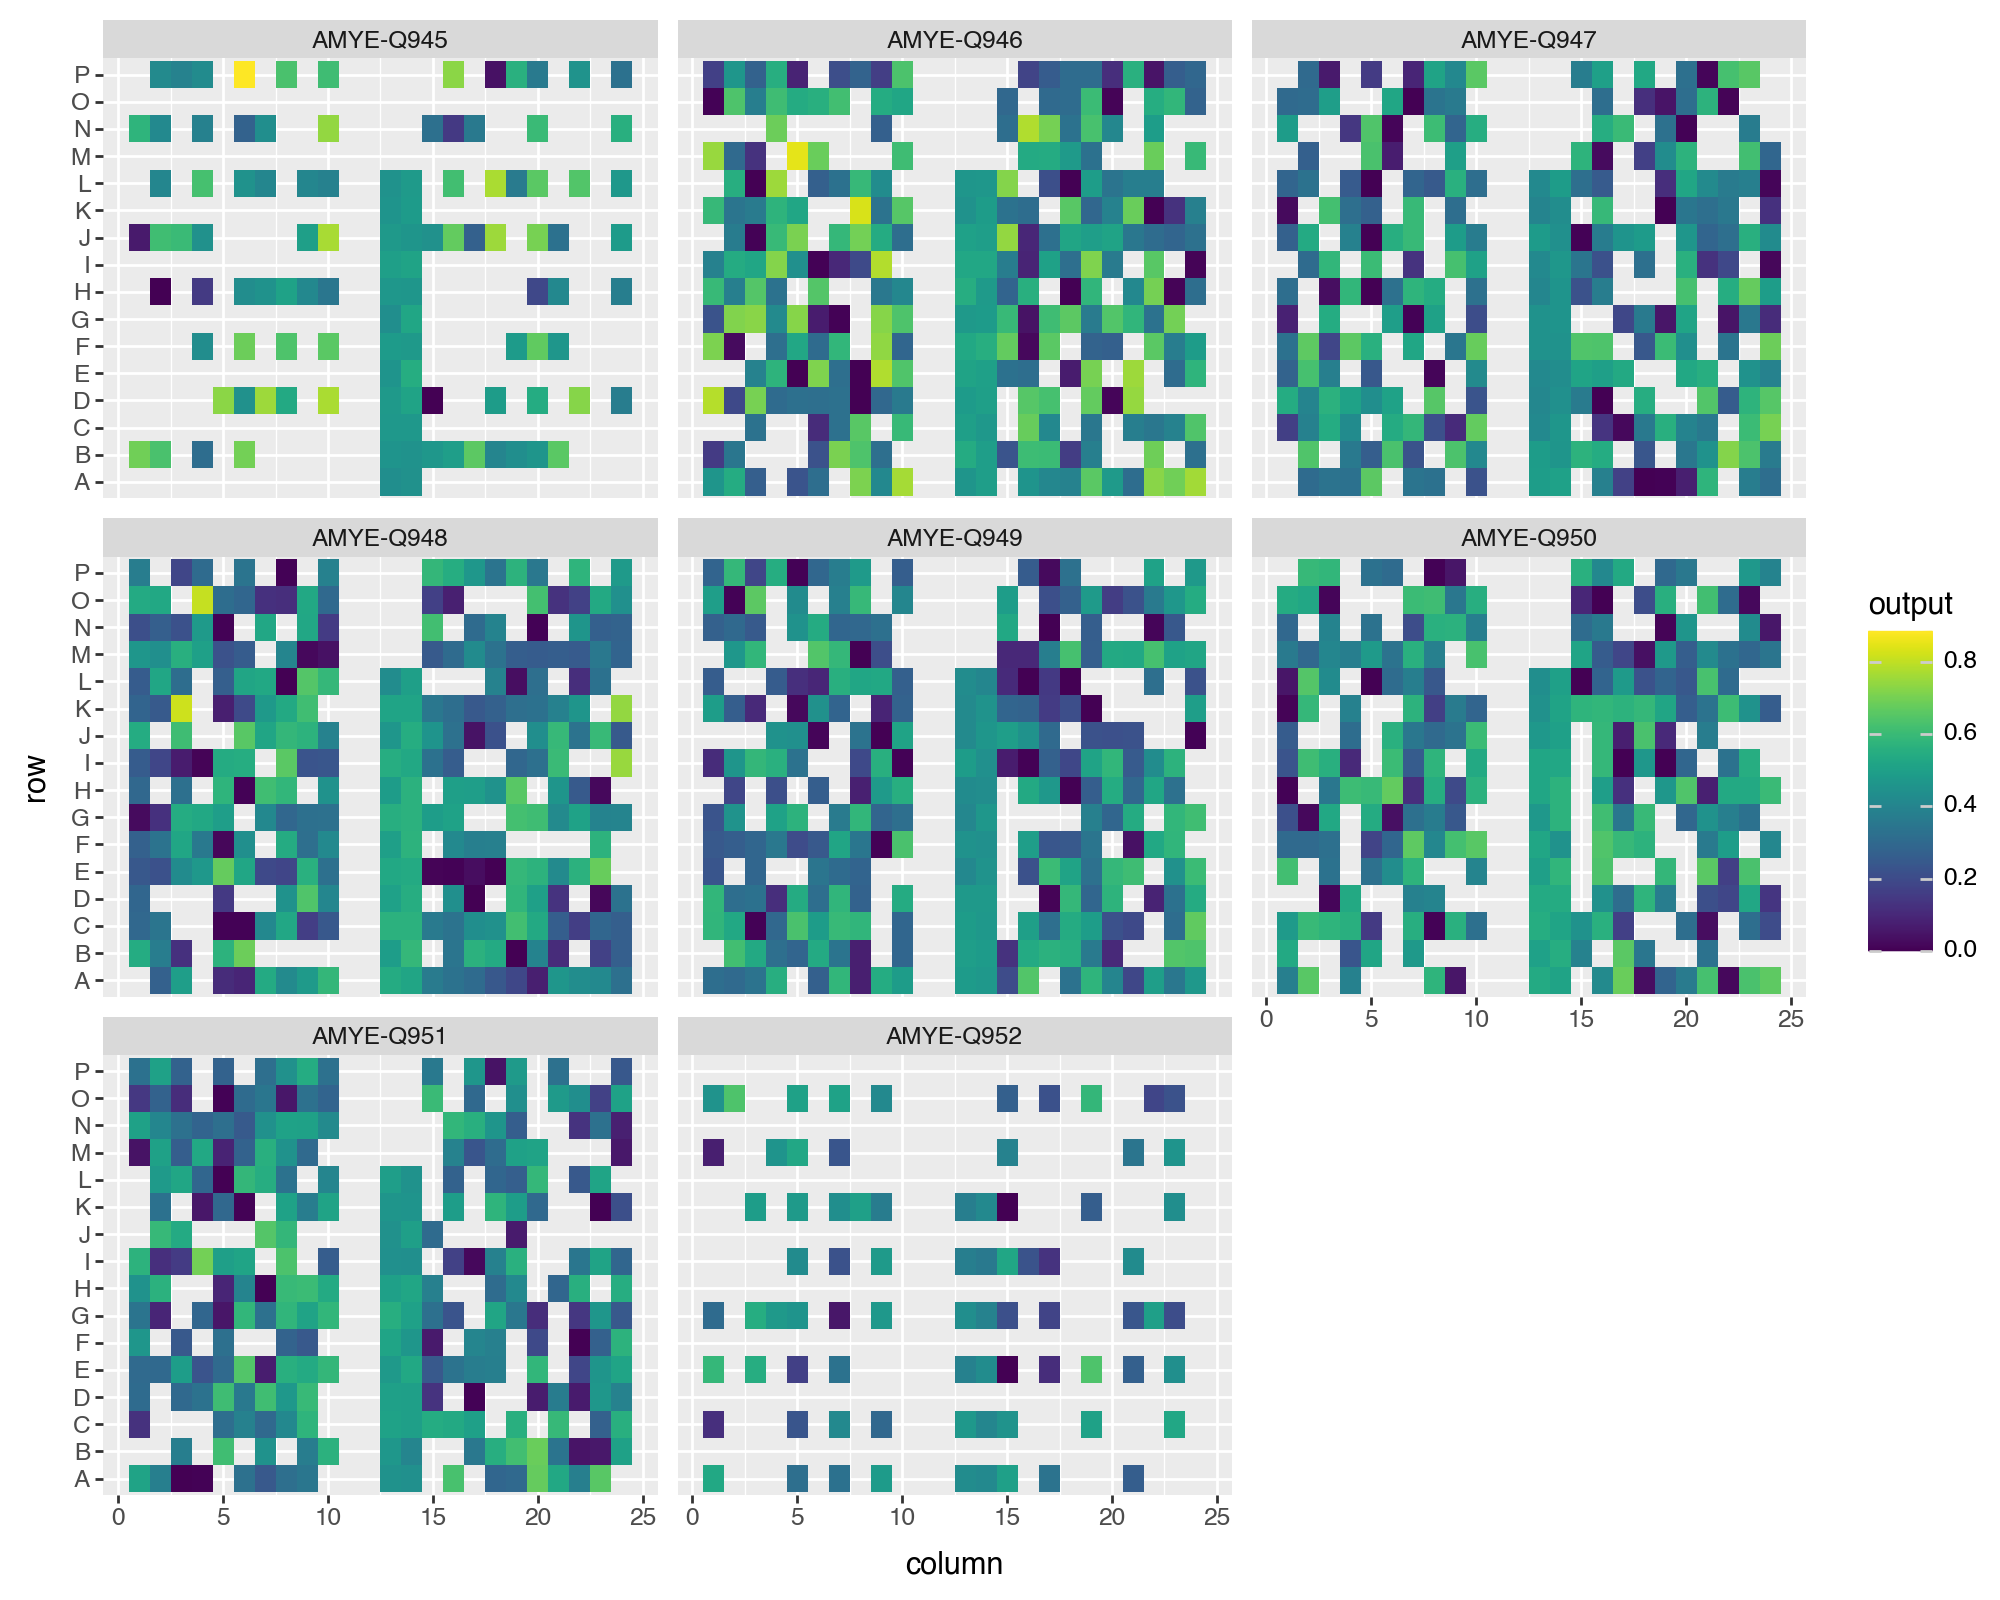

In [44]:
p9.options.set_option("figure_size", (10, 8))
(
    p9.ggplot(stability, p9.aes("column", "row", fill="output"))
    + p9.geom_tile()
    + p9.facet_wrap("~ plate_name")
)

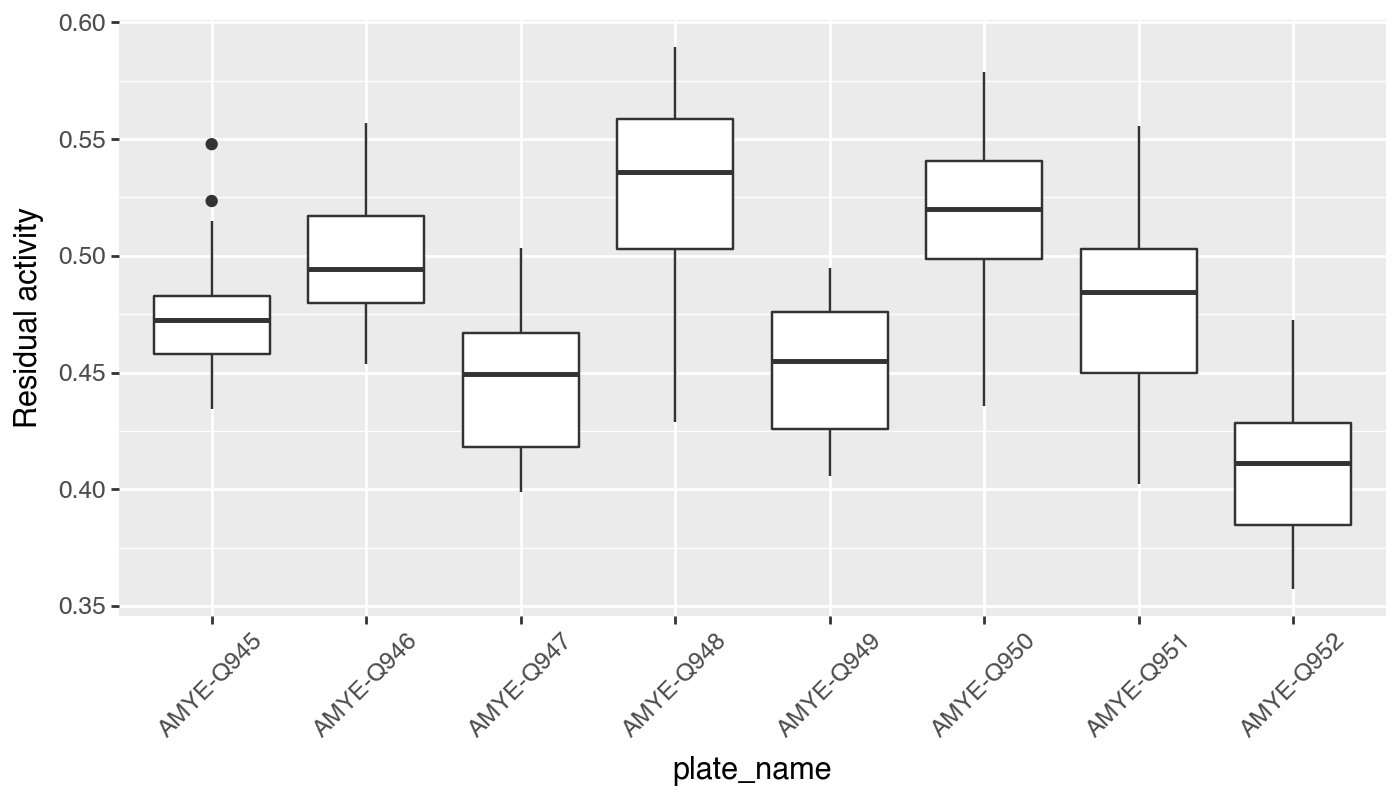

In [45]:
p9.options.set_option("figure_size", (7, 4))
(
    p9.ggplot(
        stability.query("analysis_role == 'CONTROL'"),
        p9.aes("plate_name", "output"),
    )
    + p9.geom_boxplot()
    + p9.ylab("Residual activity")
    + p9.theme(axis_text_x=p9.element_text(angle=45))
)

In [46]:
stabilityn = utils.plate_median_normalize(
    stability.copy(), controls=["AMYE-WT"], mad_scale=False
)

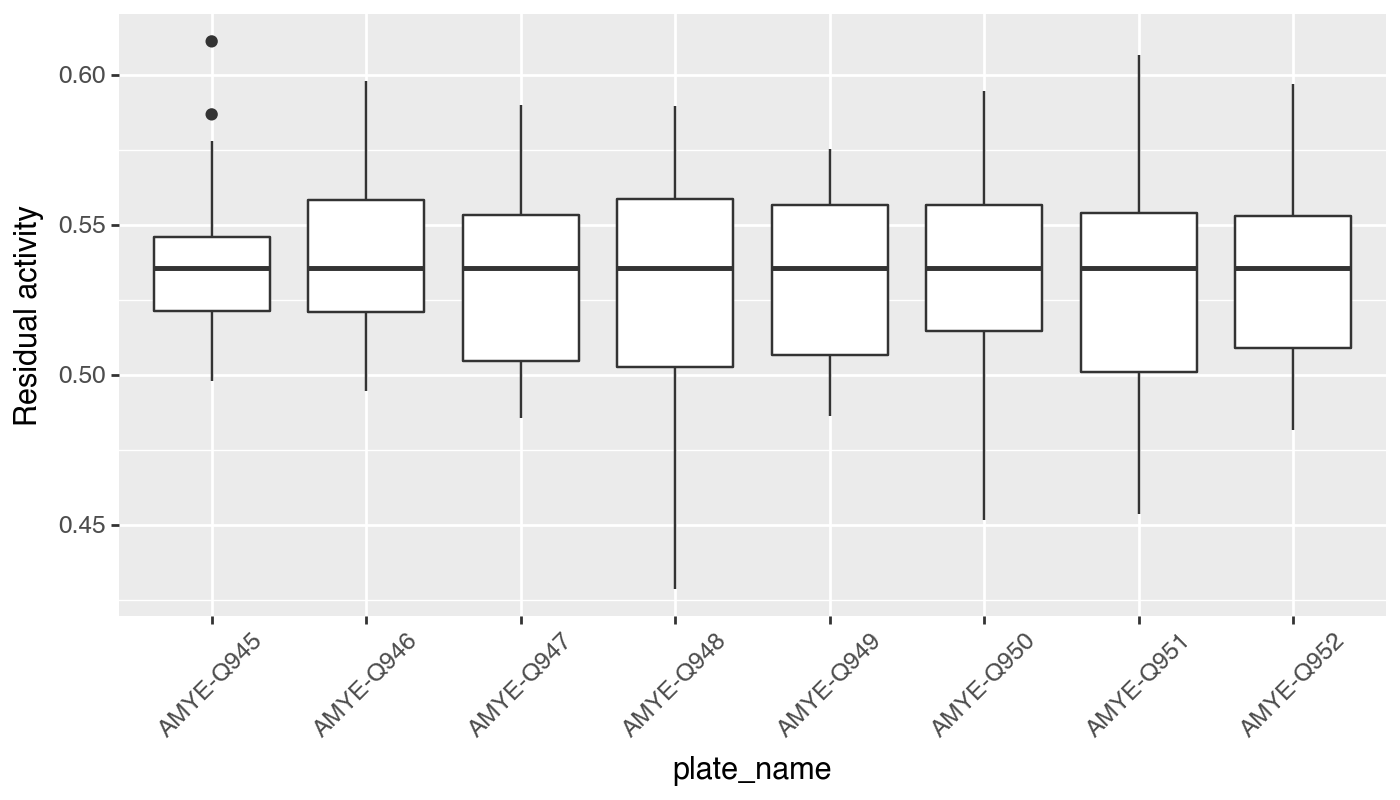

In [47]:
p9.options.set_option("figure_size", (7, 4))
(
    p9.ggplot(
        stabilityn.query("analysis_role == 'CONTROL'"),
        p9.aes("plate_name", "output"),
    )
    + p9.geom_boxplot()
    + p9.ylab("Residual activity")
    + p9.theme(axis_text_x=p9.element_text(angle=45))
)

Try median normalization. 

In [48]:
dswo = replicate_table(
    stability,
    exclude_plates=["AMYE-Q948"],
    annotation={"normalized": "Not normalized", "with_Q948": "Without Q948"},
)
dsw = replicate_table(
    stability, annotation={"normalized": "Not normalized", "with_Q948": "With Q948"}
)
dsnwo = replicate_table(
    stabilityn,
    exclude_plates=["AMYE-Q948"],
    annotation={"normalized": "Normalized", "with_Q948": "Without Q948"},
)
dsnw = replicate_table(
    stabilityn, annotation={"normalized": "Normalized", "with_Q948": "With Q948"}
)

In [49]:
dss = pd.concat([dswo, dsw, dsnwo, dsnw])

In [50]:
dss.drop(columns=["same_plate"]).groupby(["with_Q948", "normalized"]).corr(
    numeric_only=True, method="spearman"
)

s0        s1
with_Q948    normalized                           
With Q948    Normalized     s0  1.000000  0.882302
                            s1  0.882302  1.000000
             Not normalized s0  1.000000  0.888520
                            s1  0.888520  1.000000
Without Q948 Normalized     s0  1.000000  0.918014
                            s1  0.918014  1.000000
             Not normalized s0  1.000000  0.913690
                            s1  0.913690  1.000000

/Users/henning/.virtualenvs/pet-pilot/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 644 rows containing missing values.


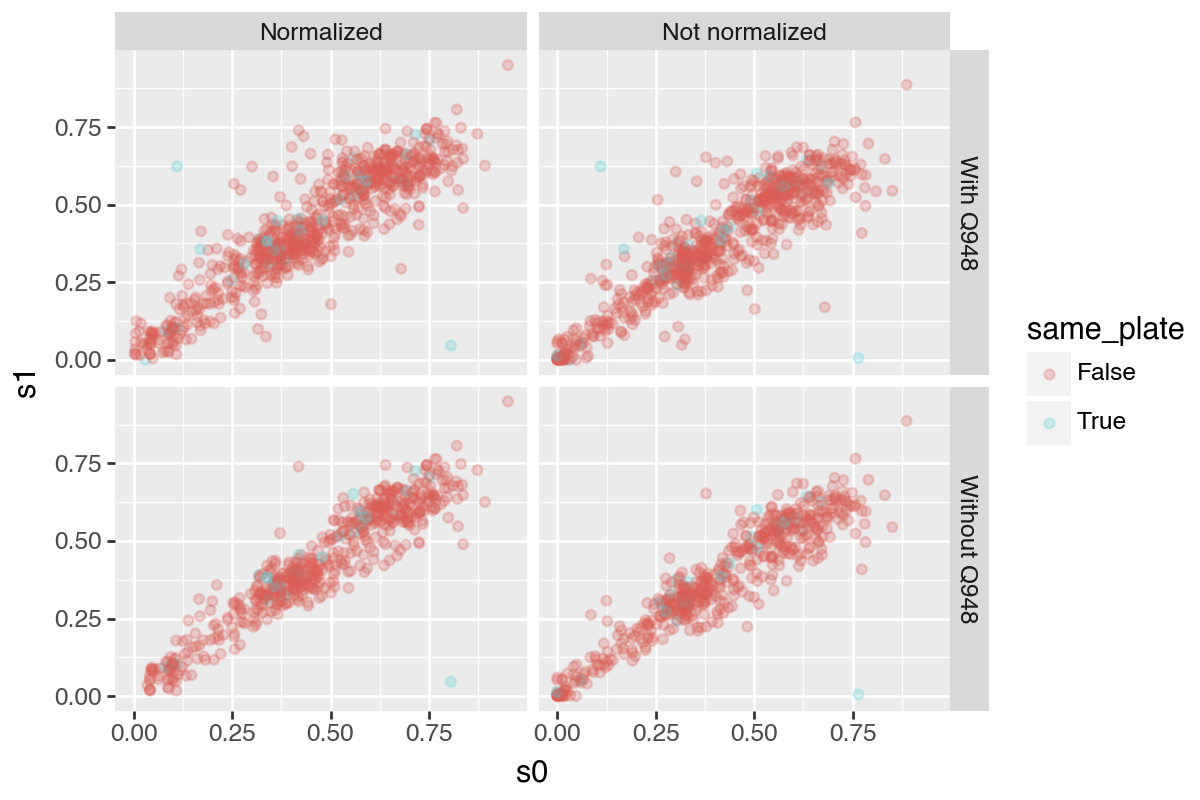

In [51]:
p9.options.set_option("figure_size", (6, 4))
(
    p9.ggplot(dss, p9.aes(x="s0", y="s1", color="same_plate"))
    + p9.geom_point(alpha=0.25)
    + p9.facet_grid("with_Q948~normalized")
    # + p9.ylim(0, 5)
    # + p9.xlim(0, 5)
)

In [52]:
f = stabilityn[
    [
        "team",
        "sequence",
        "objectid",
        "plate_name",
        "well_location",
        "analysis_role",
        "output",
    ]
].assign(target="stability")

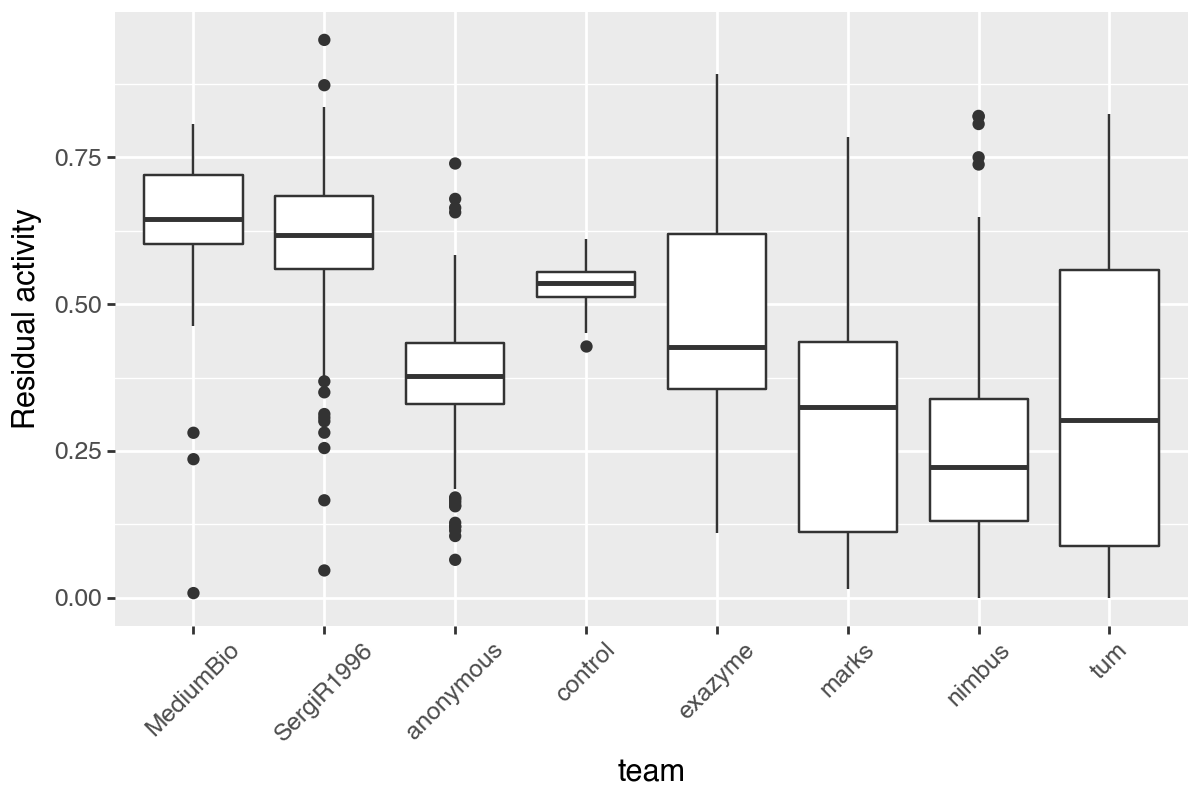

In [53]:
(
    p9.ggplot(f, p9.aes("team", "output"))
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(angle=45))
    + p9.ylab("Residual activity")
)

In [54]:
f.to_csv("output/invitro-stability.csv.gz")

## Combined

In [55]:
cc = pd.concat(
    [
        pd.read_csv("output/invitro-hplc.csv.gz", index_col=0),
        pd.read_csv("output/invitro-activity.csv.gz", index_col=0),
        pd.read_csv("output/invitro-stability.csv.gz", index_col=0),
    ]
)

In [56]:
cc.to_csv("output/invitro-all.csv.gz")